In [1]:
import numpy as np
import torch
from torch import nn, optim
import scipy as sp
import scipy.integrate
import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns
from matplotlib import rc
#rc('text', usetex=True)
rc('font', size=14)

In [2]:
#pMP_nz = lambda lam: ((np.sqrt(np.maximum(0,(lam-lm)*(lp - lam)))/lam))/(2*np.pi) * (lam < lp) * (lam > lm)

def pMP_nz(lam):
    ret = np.zeros(lam.shape)
    inds = np.nonzero((lam <= lp) * (lam >= lm) * lam)
    ret[inds] = ((np.sqrt((lam[inds]-lm)*(lp - lam[inds]))/lam[inds]))/(2.*np.pi)
    return ret

def pMP_nz_scalar(lam):
    if lam > 0 and lam <= lp and lam >= lm:
        return (np.sqrt((lam-lm)*(lp - lam))/lam)/(2.*np.pi)
    else:
        return 0
    
def cutoff_prediction(gamma):
        return (1.-alpha)*(alpha<1.) + sp.integrate.quad(pMP_nz_scalar,0,gamma)[0] + (1./snr)*sp.integrate.quad(lambda x: pMP_nz_scalar(x)/x, gamma, np.inf)[0]
    


def training_error(t):
    point_err = lambda k: 1./alpha * sp.integrate.quad(lambda x: pMP_nz_scalar(x)*(x*(1 + inr) + 1./snr)*np.exp(-2*x*k/(tau*alpha)), 0, np.inf)[0] + 1./snr*(1.-1./alpha)*(alpha>1.)
    return np.array([point_err(x) for x in t])/(1+phi)

def training_error2(t):
    point_err = lambda k: 1./alpha * sp.integrate.quad(lambda x: pMP_nz_scalar(x)*(1+x*snr)/(1+snr)*np.exp(-2*x*k/(tau)), 0, np.inf)[0]
    return np.array([point_err(x) for x in t])
    
def test_error(t):
    point_err = lambda k: sp.integrate.quad(lambda x: pMP_nz_scalar(x)*((1 + inr)*np.exp(-2*x*k/(tau*alpha)) + 1./(x*snr)*(1-np.exp(-x*k/(tau*alpha)))**2), 0, np.inf)[0] + 1./snr + (1-alpha)*(alpha<1.)
    return np.array([point_err(x) for x in t])/(1+phi)

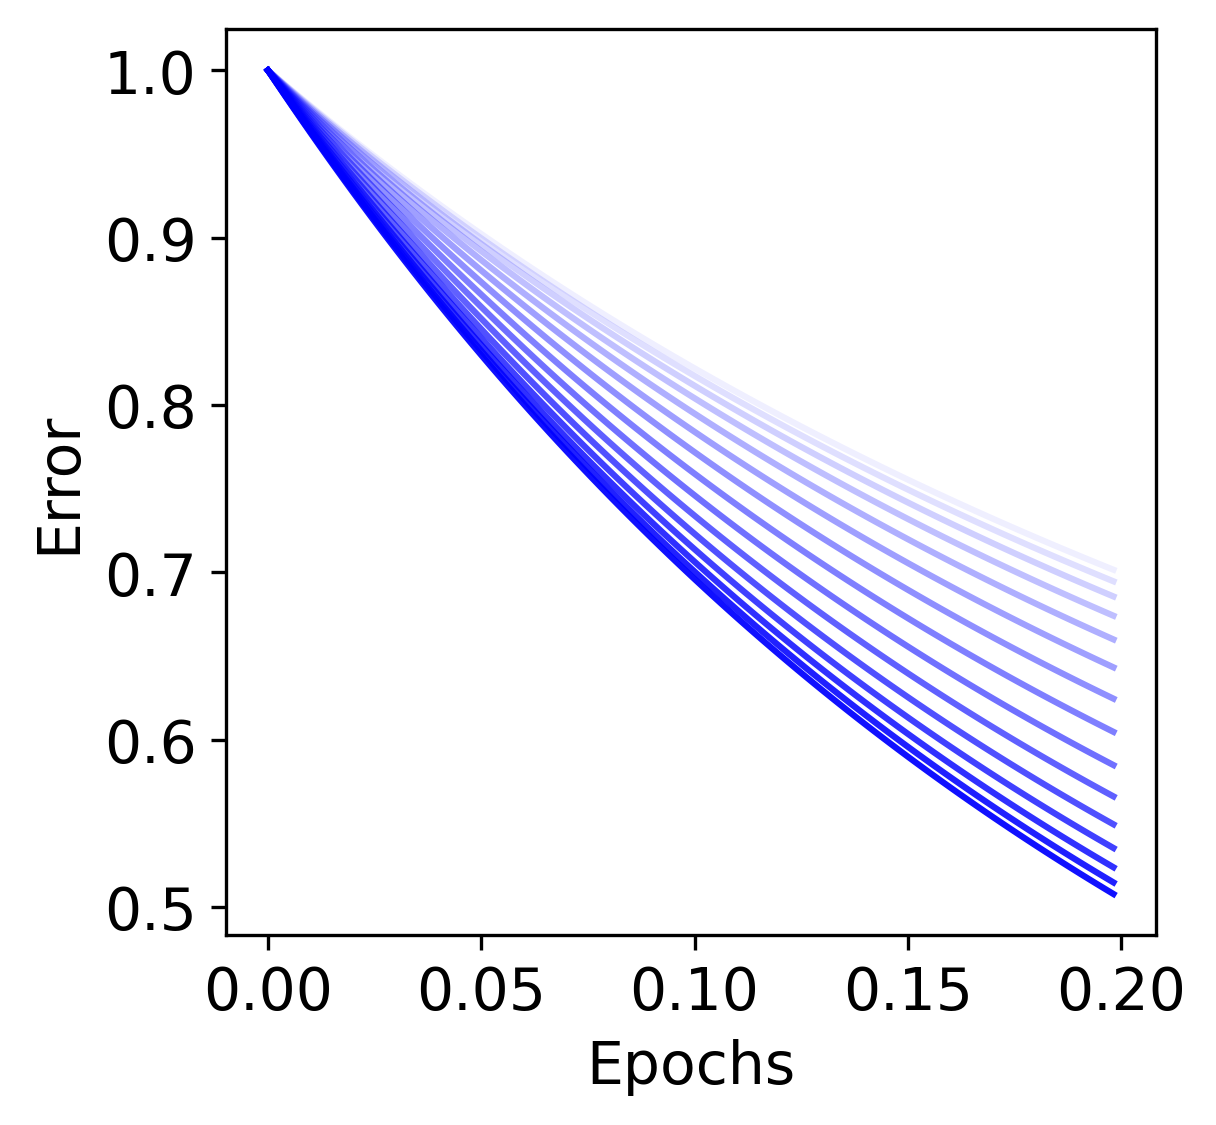

In [33]:
import os
from os.path import exists


# Plot train/test err
t = np.linspace(0.,2,1000)

SNR_vec = np.arange(-4,4,0.5)
SNR = 2**SNR_vec
plt.figure(figsize = (4,4),dpi=300)

#plt.legend()
for i,snr in enumerate(SNR):
    
    alpha = 1
    phi = 1/snr
    inr = 0
    tau = 1
    Tmax = 10

    lp = (np.sqrt(alpha) + 1)**2
    lm = (np.sqrt(alpha) - 1)**2
    plt.plot(t[0:100],training_error2(t)[0:100],'b',alpha= i/(len(SNR)))
      
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.savefig('decay_initial.pdf')

plt.show()

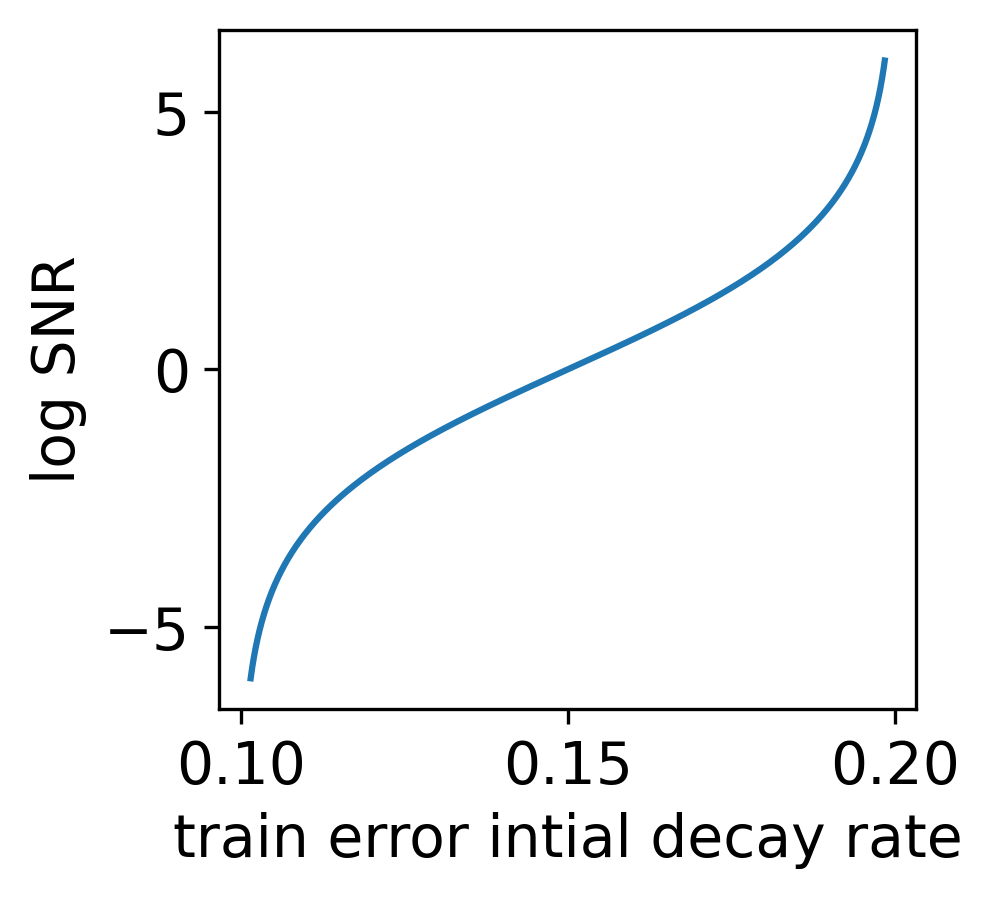

In [20]:
# Plot derivative as fn of SNR
alpha = 1
phi = 1/snr
inr = 0
tau = 1/0.05 #tau = 1/lr
Tmax = 10
def training_error_initial_slope(s):
    point_slope = lambda k: 1./alpha * sp.integrate.quad(lambda x: pMP_nz_scalar(x)*(1+x*k)/(1+k)*(-2*x/tau), 0, np.inf)[0]
    return np.array([point_slope(x) for x in s])


s = np.logspace(-6,6,num=600,base = 2)

slopes_table = training_error_initial_slope(s)


# plt.plot(s,slopes_table)
# plt.xlabel('SNR')
# plt.ylabel('d/dt train error')
# plt.show()


plt.figure(figsize = (3,3),dpi =300)
plt.plot(-slopes_table,np.log2(s))
plt.ylabel('log SNR')
plt.xlabel('train error intial decay rate')
plt.savefig('look_up_table.pdf')
plt.show()


In [5]:
from task import TSN

N = 3000
out_dim = 1
P =3000
P_test = 1000
lr_tsn = 0.05
nepoch_tsn = 100

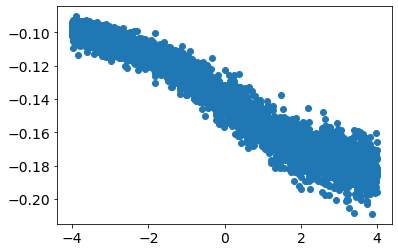

In [47]:
#SNR_vec = np.arange(0.02,5,0.02)

SNR_vec = np.arange(-4,4,0.02)
SNR_vec = 2**SNR_vec
SNR_vec = np.repeat(SNR_vec,10) #generate multiple teachers for each SNR

alt_train = torch.zeros(len(SNR_vec),nepoch_tsn)
alt_test = torch.zeros(len(SNR_vec),nepoch_tsn)

SNR_train = torch.zeros(len(SNR_vec),1)
SNR_test = torch.zeros(len(SNR_vec),1)

for i,SNR in enumerate(SNR_vec):
    
    if SNR == np.inf:
        variance_w = 1;
        variance_e = 0;
    else:
        variance_w = SNR/(SNR + 1);
        variance_e = 1/(SNR + 1);
        
    # generate learning trajectories    
    teacher = TSN.TSN(N,out_dim, P, P_test,SNR,lr_tsn,i)
    
    Et, _ = teacher.training_loop(nepoch_tsn,0)

    alt_train[i,:] = torch.tensor(np.squeeze(Et))
    SNR_train[i,:] = SNR

train_final = torch.diff(alt_train)


plt.scatter(np.log2(SNR_train),train_final[:,0])


In [48]:
def predict_SNR(lookup_table,values,SNRs):
    lookup_table = np.asarray(lookup_table)
    predicted_SNRs =  np.zeros((len(values),1))

    for i,value in enumerate(values):
        idx = (np.abs(lookup_table - value)).argmin()
        predicted_SNRs[i] = SNRs[idx]
    return predicted_SNRs

In [49]:
result  = predict_SNR(slopes_table,train_final[:,0].numpy(),np.log2(s))

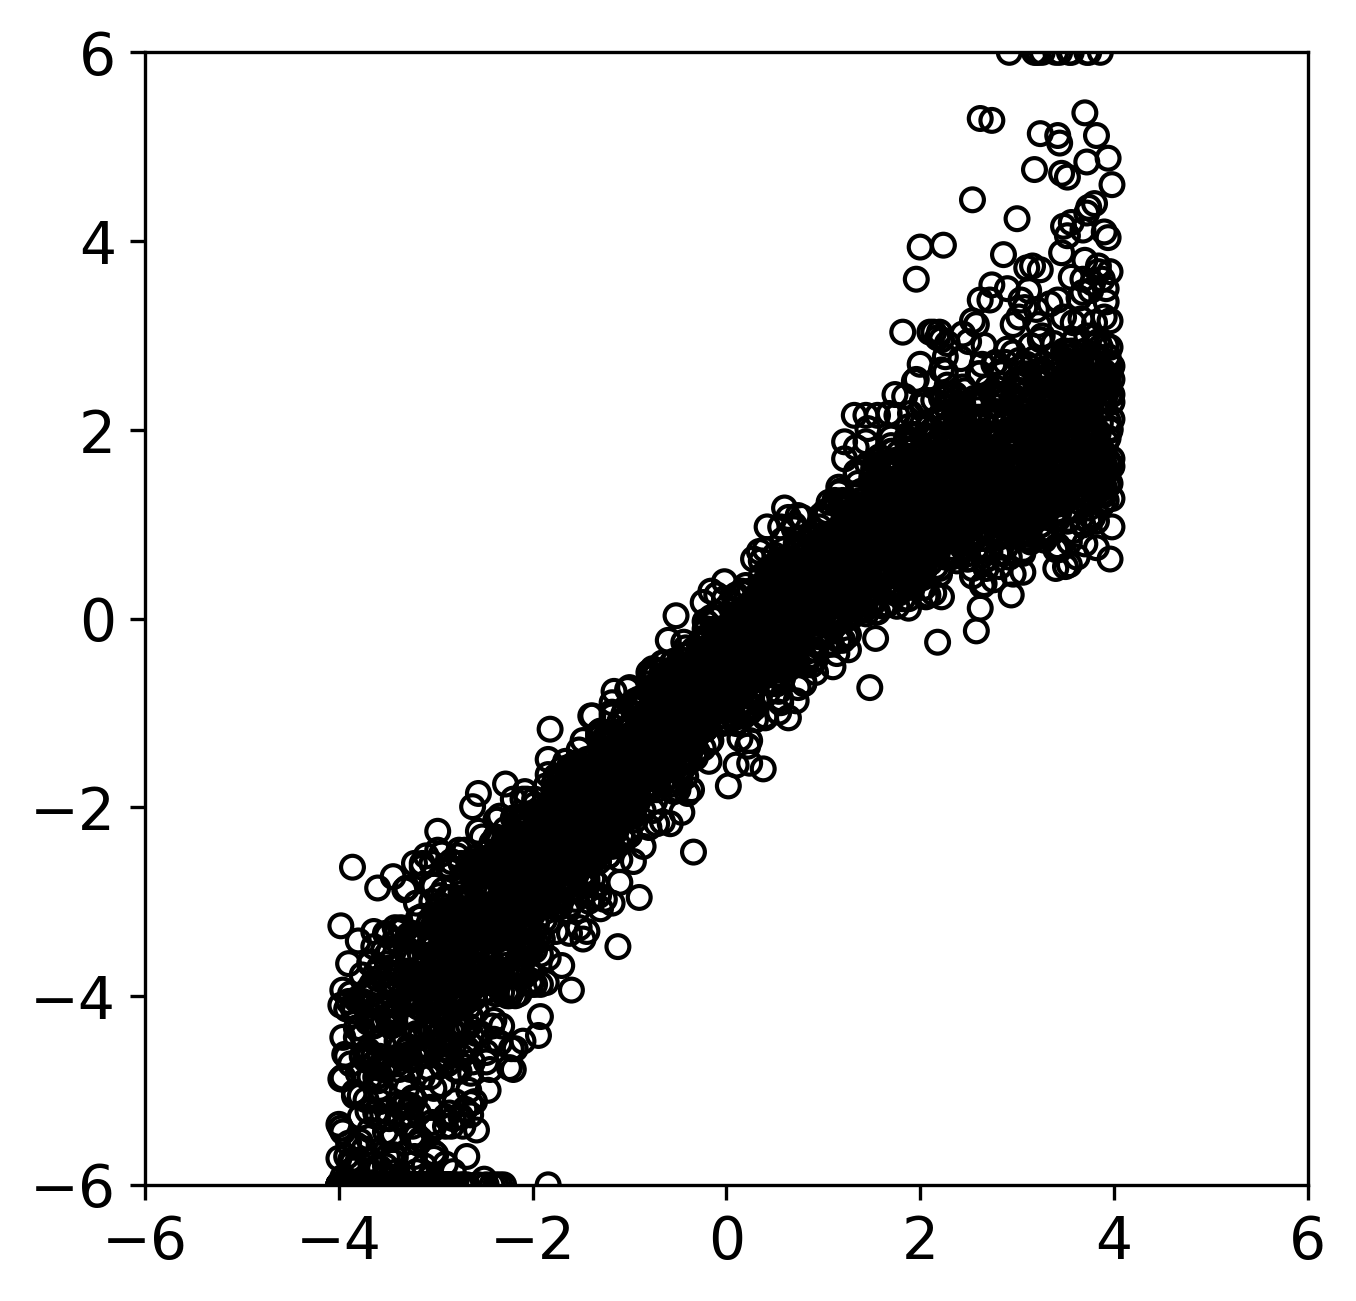

In [50]:
plt.figure(figsize = (5,5),dpi = 300)
plt.scatter(np.log2(SNR_train), result,s=30, facecolors='none', edgecolors='k')
plt.xlim(-6,6)
plt.xticks(np.arange(-6, 8, 2))

plt.ylim(-6,6)
plt.yticks(np.arange(-6, 8, 2))


plt.savefig('Rate_scatter.pdf')